# __Country Music Lyric Analysis__
#### Analyzing song lyrics with natural language processing and Non-negative Matrix Factorization (NMF) / Correlation Explanation (CorEx) topic models  
<hr>  
This project explores Country music as a genre by extracting and analyzing lyrics from songs posted on Billboard's weekly hot 50 charts. Topic modeling, though not an exhaustive approach, proves useful in exploring music genres by allowing users to discover previously hidden themes and motifs in song lyrics. Introducing a time series element to the dataset also allows users to visualize trends in topic distributions over several decades.     

In this case, the models and visualizations demonstrate how country music can in fact, be quite relatable; namely, that its lyrics represent a lot more than just beer, trucks, and women (themes commonly present in modern day bro-country). Applying CorEx / word anchors in a semi-supervised learning manner also reveals some more interesting, esoteric topics in Country music.  

The project can be broken down into the following steps:  

#### 1. Data Acquisition  
\- 1a. Scrape Billboard chart archives and populate corpus of country songs  
\- 1b. Scrape lyrics for each song from WikiLyrics and Genius APIs
#### 2. Preprocessing - Lyrics / Data   
\- 2a. Use natural language processing and other methods to process text lyrics and data. Introduce some EDA and basic feature engineering    
#### ***3. Topic Models / Lyric Analysis***  
\- ***3a. Apply non-negative matrix factorzation and CorEx to model topics and then analyze the results***  



# __3a. Topic Models / Lyric Analysis__

### __Sections__  

[3a1. Load / Process Lyrics](#3a1)  
[3a2. Non-negative Matrix Factorization - Topic Model](#3a2)  
[3a3. Non-negative Matrix Factorization - Results / Analysis (Version 1)](#3a3)  
[3a4. Non-negative Matrix Factorization - Results / Analysis (Version 2)](#3a4)   
[3a5. CorEx - Topic Model](#3a5)  
[3a6. CorEx - Results / Analysis (Version 1)](#3a6)  
[3a7. CorEx - Results / Analysis (Version 2)](#3a7)  
[3a8. CorEx - Results / Analysis (Version 3)](#3a8)  
[3a9. Corex - Anchor Exploration](#3a9)


In [1]:
import pandas as pd
import numpy as np
import warnings
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import NMF, TruncatedSVD
from corextopic import corextopic as ct
from corextopic import vis_topic as vt

from rq_config import project_4_path

warnings.filterwarnings('ignore')
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
data_dir = os.path.join(project_4_path,'data/')

In [3]:
tracks_df = pd.read_pickle(data_dir + 'lyrics_processed_df.pkl')

In [4]:
tracks_df.shape

(8653, 13)

In [5]:
tracks_df.head()

,artist,lyrics,source,title,week_count,weeks,median_year,characters,word_count,line_count,unique_count,lexical_density,lyrics_processed
0,Alabama,Lyin' beside you watching you sleepin'\nAfter ...,wikilyrics,"""You've Got"" The Touch",15,"1987-04-26,1987-04-19,1987-04-12,1987-04-05,19...",1987,1204,252,49,84,0.333333,lyin beside watching sleepin loved tenderly se...
1,Billie Jo Spears,Come and look at this old faded photograph\nHo...,wikilyrics,'57 Chevrolet,9,"1978-10-15,1978-10-08,1978-10-01,1978-09-24,19...",1978,1122,232,33,106,0.456897,come look old faded photograph honey tell brin...
2,Wynn Stewart,\n\nA flower needs the earth to make it grow\n...,genius,'Cause I Have You,14,"1967-10-22,1967-10-15,1967-10-08,1967-10-01,19...",1967,540,117,19,68,0.581197,flower need earth make grow river need rain ma...
3,Clay Walker,"'Bout ten years old, hide and seek\nI found me...",wikilyrics,'Fore She Was Mama,25,"2007-03-18,2007-03-11,2007-03-04,2007-02-25,20...",2006,1448,280,52,160,0.571429,bout ten year old hide seek found closet ready...
4,Sawyer Brown,Sue and Jack fell in love 'round here \nThey b...,wikilyrics,'Round Here,12,"1996-02-25,1996-02-18,1996-02-11,1996-02-04,19...",1996,1017,203,27,71,0.349754,sue jack fell love round goin steady year affo...


In [6]:
# Tune tfidf parameters

tfidf_vectorizer = TfidfVectorizer(max_features = None,
                                   max_df = .4,
                                   min_df = 10,
                                   stop_words = 'english')

In [7]:
# Tune count_vectorizer parameters

count_vectorizer = CountVectorizer(max_features=None,
                                   max_df = .6,
                                   min_df = 10,
                                   stop_words='english', token_pattern="\\b[a-z][a-z]+\\b",
                                   binary=True)

In [8]:
def word_vectorizer(df,vectorizer = None):
    """
    Input documents/lyrics to return sparse matrix vectors
    
    Parameters
    -----
    df: Dataframe with country songs and lyrics
    vectorizer: select 'tfidf' or 'count'
    
    Returns
    -----
    vectors: vectors for each document
    labels: word labels from corpus
    """
    #Fit / vectorize lyrics
    if vectorizer == 'tfidf':
        vectors = tfidf_vectorizer.fit_transform(df['lyrics'].apply(lambda x: str(x)))
        labels = tfidf_vectorizer.get_feature_names()
    elif vectorizer == 'count':
        vectors = count_vectorizer.fit_transform(df['lyrics'].apply(lambda x: str(x)))
        labels = count_vectorizer.get_feature_names()
    else:
        print('Warning: No vectorizer specified')
        
    return vectors, labels

<a id='3a2'></a>

### __3a2. Non-negative Matrix Factorization - Topic Model with Term Frequency-Inverse Document Frequency__

#### NMF Model Pipeline

In [9]:
def nmf_topic_model(df,number_of_topics,vectors,labels):
    """
    Run non-negative matrix factorization model to extract topics from country lyrics
    
    Parameters
    -----
    df: dataframe containing lyrics / country songs
    number_of_topics: number of topics to extract
    vectors: lyrics in vector format
    labels: vector labels
    
    Returns
    -----
    df_merged: dataframe with topics and results
    nmf_model: NMF model object to visualize features
    topics_columns: column names which will be used to aggregate topics across decades / years
    """
    # Tune NMF model
    nmf_model = NMF(n_components=number_of_topics,
                random_state=1,
                alpha=.05,
                l1_ratio=.3,
                init='nndsvd')
    # Fit NMF model
    nmf_model.fit(vectors)
    
    # Find topics 
    topics = nmf_model.transform(vectors)
    df_topics = pd.DataFrame(topics)
    topics_columns = list(df_topics.columns)
    
    # Merge topics with original tracks
    df_merged = pd.merge(df,df_topics,left_index = True,right_index = True)
    # Create separate column with "highest likelihood" topic
    df_merged['topic'] = df_merged.loc[:,topics_columns].idxmax(axis = 1)
    
    return df_merged, nmf_model, topics_columns

In [10]:
def normalize_nmf_topics(df,topics_columns):
    """
    Normalize topic distributions for each track by normalizing to percentage
    
    Parameters
    -----
    df: dataframe with merged NMF model results
    topics_columns: column labels in dataframe related to topics
    
    Returns
    -----
    df: Updated dataframe with 'norm' columns for respective topic
    """
    
    df['topic_sum'] = df.loc[:,topics_columns].sum(axis = 1)
    topics_norm_columns = [str(topic) + '_norm' for topic in topics_columns]
    df[topics_norm_columns] = df.loc[:,topics_columns].apply(lambda x: x/df['topic_sum']*100)
    return df

In [11]:
def aggregate_nmf_topics_year(df,topics_columns):
    """
    Aggregates topics by years and returns a dataframe with years and their respective topic distributions
    
    Parameters
    -----
    df: dataframe with merged NMF model results
    topics_columns: column labels in dataframe related to topics
    
    Returns
    ----
    year_agg_topics: dataframe containing aggregated topics by year
    """
    
    #Unflatten by weeks df_merged to calculate the mean "topic" value for each year (e.g. 15 extra rows for track if week_count == 15)
    unflattened_df_merged = (pd.DataFrame(df.values.
                                          repeat(df['week_count'],axis = 0),
                                          columns = df.columns))
    
    topics_norm_columns = [str(topic) + '_norm' for topic in topics_columns]
    unflattened_df_merged['median_year'] = pd.to_datetime(unflattened_df_merged['median_year'],format = '%Y').dt.year    
    unflattened_df_merged[topics_norm_columns] = unflattened_df_merged.loc[:,topics_norm_columns].apply(pd.to_numeric)


    # Create m x n dataframe with m = years, n = topics
    year_agg_topics = unflattened_df_merged.groupby('median_year')[topics_norm_columns].mean().reset_index()
    year_agg_topics['median_year'] = pd.to_datetime(year_agg_topics['median_year'],format = '%Y').dt.year
    return year_agg_topics

In [12]:
def nmf_model_pipeline(df,vectorizer,number_of_topics):
    """
    Pipeline all functions above for non-negative matrix factorization model  
    
    Parameters
    -----
    df: tracks dataframe containing lyrics and all country songs
    vectorizer: specify vectorizier TFIDF or count
    number_of_topics: specify number of topics to extract from NMF model
    
    Returns
    -----
    df_merged: tracks dataframe with merged topics
    df_year_agg_topics: dataframe with topics aggregated by year
    nmf_model: NMF Model object
    labels: vectors / topic labels
    topics_columns: column labels in dataframe related to topics
    """
    vectors, labels = word_vectorizer(df,vectorizer = vectorizer)
    df_merged, nmf_model, topics_columns = nmf_topic_model(df,number_of_topics,vectors,labels)
    df_merged = normalize_nmf_topics(df_merged,topics_columns)
    df_year_agg_topics = aggregate_nmf_topics_year(df_merged,topics_columns)
    
    return df_merged, df_year_agg_topics, nmf_model, labels, topics_columns

#### Visualization Functions:

In [13]:
def display_nmf_topics(model, feature_names, number_of_topic_words, topic_names=None):
    """
    Print / display topics and respective vectors / features in each topic from model
    
    Parameters
    -----
    model: model object
    feature_names: labels / words from each topic
    number_of_topic_words: Specify number of words to display from each topic
    topic_names:
    
    Returns
    -----
    string of all topics and respective features
    """
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("Topic ", ix)
        else: 
            print("Topic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-number_of_topic_words - 1:-1]]))

In [14]:
def plot_topics(years,df):
    """
    Visualize and plot topic distributions across scraped date range
    
    Parameters
    -----
    years: column containing time series / date information
    df: dataframe of tracks with merged NMF/Corex results
    """
    plt.figure(figsize = (16,10))
    plt.xlabel('Year')
    plt.ylabel('Distribution')
    for topic in df.columns[1:]:
        sns.lineplot(x = years,y = topic,data = df,label = topic)

<a id='3a3'></a>

### __3a3. Non-negative Matrix Factorization - Model Results / Analysis (Version 1)__  
#### Run NMF Model with 10 topics:

In [15]:
vectorizer = 'tfidf'
number_of_topics = 10

In [16]:
# Run NMF Model and pull results

tracks_nmf_df_1, tracks_year_agg_nmf_df_1,nmf_model_1,nmf_labels_1, nmf_topics_1 = nmf_model_pipeline(tracks_df,vectorizer,number_of_topics)

In [17]:
# Topics / results from NMF model

display_nmf_topics(nmf_model_1,nmf_labels_1,20)

Topic  0
want, heart, need, make, true, tell, somebody, hold, feel, say, believe, fall, way, arms, fool, eyes, break, cause, broken, hurt
Topic  1
got, little, yeah, girl, country, good, hey, bit, big, boy, thing, old, pretty, town, gotta, right, money, daddy, em, road
Topic  2
baby, come, crazy, long, tell, ooh, right, night, good, maybe, tonight, need, girl, kiss, lovin, thing, feel, honey, look, wrong
Topic  3
gonna, tonight, gotta, yeah, make, live, someday, better, alright, night, somebody, time, break, right, hey, cause, miss, won, day, till
Topic  4
oh, yeah, life, whoa, wish, ooh, good, girl, way, sweet, darlin, think, yes, dream, world, blue, feel, woah, crazy, lonesome
Topic  5
man, woman, stand, hand, understand, needs, good, kind, better, loves, knows, touch, life, hands, cause, lord, hold, lovin, wife, hard
Topic  6
wanna, make, yeah, kiss, feel, song, makes, girl, dance, night, gotta, ya, hear, lovin, rock, slow, fall, sing, tonight, play
Topic  7
time, gone, said, way, l

#### Topics 0, 1, and 7 show the most distinct patterns:  
- Topic 0: Songs about heartbreak have decreased since the 60s.  
- Topic 1: Words with more positive connotations have increased and are the most popular recently.  
- Topic 7: Songs about time and life have decreased significantly since the 60s.

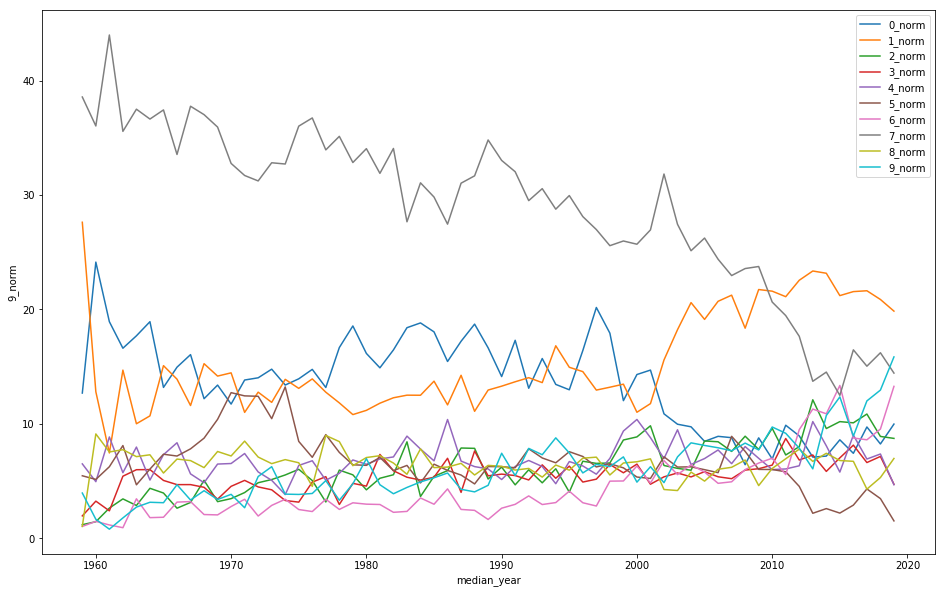

In [18]:
# Plot normalized topics and how they have evolved over the years

plot_topics('median_year',tracks_year_agg_nmf_df_1)

<a id='3a4'></a>

### __3a4. Non-negative Matrix Factorization - Model Results / Analysis (Version 2)__  
#### Run NMF Model with 5 topics:

In [19]:
vectorizer = 'tfidf'
number_of_topics = 5

In [20]:
# Run NMF Model and pull results

tracks_nmf_df_2, tracks_year_agg_nmf_df_2,nmf_model_2,nmf_labels_2, nmf_topics_2 = nmf_model_pipeline(tracks_df, vectorizer,number_of_topics)

In [21]:
# Topics / results from NMF model

display_nmf_topics(nmf_model_2,nmf_labels_2,20)

Topic  0
time, heart, say, way, let, away, gone, mind, tell, think, make, won, come, day, long, cause, world, want, feel, life
Topic  1
got, ain, little, man, good, girl, yeah, said, old, woman, country, big, home, boy, cause, town, hey, right, thing, night
Topic  2
baby, wanna, let, want, come, make, girl, need, right, kiss, crazy, tonight, yeah, little, hold, tell, feel, night, got, hey
Topic  3
gonna, ain, tonight, gotta, time, make, live, yeah, somebody, long, right, cause, someday, alright, night, gone, break, better, won, leave
Topic  4
oh, yeah, life, whoa, wish, ooh, girl, good, way, sweet, think, darlin, yes, world, blue, dream, woah, feel, crazy, lonesome


#### Topics 0, 1, and 2 show the most distinct patterns:  
- Topic 0: Represents one end of the spectrum in country songs / themes; wistful, generally sadder lyrics and themes have seen a sharp decrease since 1960.
- Topic 1: Is constant throughout the years which makes sense because most of the words in this topic are general words one would find in most country songs.
- Topic 2: Represents the other end of country songs (bro-country). Generally more playful / upbeat / 

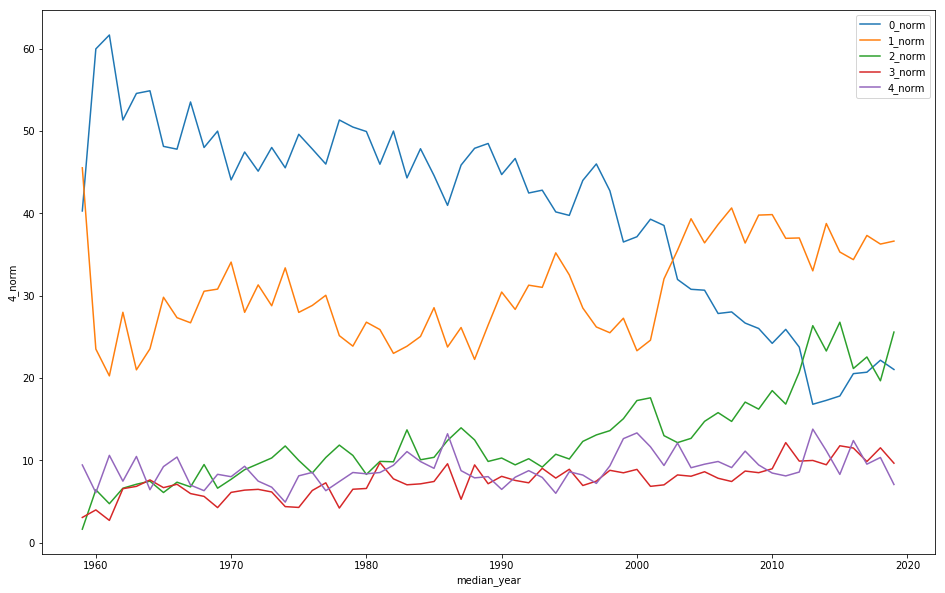

In [22]:
# Plot normalized topics and how they have evolved over the years

plot_topics('median_year',tracks_year_agg_nmf_df_2)

<a id='3a5'></a>

### __3a5. CorEx - Topic Model__

In [23]:
# Vectorize lyrics for CorEx model with CountVectorizer

corex_vectors,corex_labels = word_vectorizer(tracks_df,vectorizer = 'count')

In [24]:
def corex_topic_model(df,vectors,labels,number_of_topics,anchor_strength,anchors):
    """
    Run CorEX model on country song lyrics to extract lyric topics with or without word anchors
    
    Parameters
    -----
    df: dataframe of country tracks and lyrics
    vectors: vectorized lyrics
    labels: word labels from vectorized lyrics
    number_of_topics: specify number of topics to extract from Country lyrics
    anchor_strength: specify strength of word anchors
    anchors: specify word anchor to "guide" CorEx model / topic discovery
    
    Returns
    -----
    df_merged: dataframe with topics and results
    corex_model: CorEx model object to visualize features
    topics_columns: column names which will be used to aggregate topics across decades / years
    """
    # Instantiate CorEx model
    corex_model = ct.Corex(n_hidden = number_of_topics,words = labels, seed = 1)
    
    # Include anchor strength / anchors if specified
    if anchors:
        corex_model.fit(vectors, words=labels, docs=df['lyrics'], 
                    anchors=anchors, anchor_strength=anchor_strength)
    else: 
        corex_model.fit(vectors, words=labels, docs=df['lyrics'])
    
    # Extract topics from corex model and append to dataframe
    topics = corex_model.p_y_given_x
    df_topics = pd.DataFrame(topics)
    topics_columns = list(df_topics.columns)
    
    # Merge topics with original tracks
    df_merged = pd.merge(df,df_topics,left_index = True,right_index = True)
    # Create separate column with "highest likelihood" topic
    df_merged['topic'] = df_merged.loc[:,topics_columns].idxmax(axis = 1)
    
    return df_merged,corex_model,topics_columns

In [25]:
def aggregate_corex_topics_sum(df):
    """
    Aggregates topics by years and returns a dataframe with years and their respective topic distributions
    
    Parameters
    -----
    df: dataframe of country songs and respective topic distributions
    topics_columns: column names which will be used to aggregate topics across decades / years
    
    Returns
    -----
    topic_year_agg: dataframe with topics aggregated by year

    """
    df_grouped = df.groupby(['median_year','topic'])['topic'].count().to_frame('count').reset_index()
    year_sum = df_grouped.groupby('median_year')['count'].sum().to_frame('year_sum').reset_index()
    topic_year_agg = pd.merge(df_grouped,year_sum,on = 'median_year')
    topic_year_agg['topic_pct'] = topic_year_agg['count'] / topic_year_agg['year_sum'] * 100
    
    return topic_year_agg                      

In [26]:
def display_corex_topics(model,number_of_topic_words):
    """
    Function to print individual topics and words / features within topics
    
    Parameters
    -----
    model: CorEx model object
    number_of_topic_words: Specify number of words to display within each topic
    
    Returns
    -----
    string of all topics and respective features
    """
    topics = model.get_topics(n_words = number_of_topic_words)
    for n,topic in enumerate(topics):
        topic_words,_ = zip(*topic)
        print('{}: '.format(n) + ', '.join(topic_words))

In [27]:
def corex_model_pipeline(df,vectorizer,number_of_topics,anchor_strength,anchors = None):
    """
    Pipeline all functions above for CorEx topic model
    
    Parameters
    -----
    df: dataframe of country tracks and lyrics
    vectorizer: specify vectorizier TFIDF or count
    number_of_topics: specify number of topics to extract from Country song corpus
    anchor_strength: specify strength of word anchors
    anchors: specify word anchor to "guide" CorEx model / topic discovery
    
    Returns
    -----
    df_merged: dataframe with topics and results
    df_year_agg_topics: dataframe with topics aggregated by year
    corex_model: CorEx model object to visualize features
    labels: word / vector labels
    topics_columns: column names which will be used to aggregate topics across decades / years
    """
    
    vectors, labels = word_vectorizer(df,vectorizer = vectorizer)   
    df_merged, corex_model, topics_columns = corex_topic_model(df,vectors,labels,number_of_topics,anchor_strength,anchors)
    df_year_agg_topics = aggregate_corex_topics_sum(df_merged)
    
    return df_merged, df_year_agg_topics, corex_model, labels, topics_columns


<a id='3a6'></a>

### __3a6. CorEx - Model Results / Analysis (Version 1)__  
#### Run CorEx with no anchors to explore initial model topics / results:

In [28]:
# Count vectorizer works best with CorEx
vectorizer = 'count'
anchors = None
number_of_topics = 5
anchor_strength = 2

In [29]:
# Run Corex Model

(tracks_corex_df_1,
 tracks_year_agg_corex_df_1,
 corex_model_1,
 corex_labels_1,
 corex_topics_columns_1) = corex_model_pipeline(tracks_df,'count',number_of_topics,anchor_strength,anchors = anchors)

#### CorEx Topics are more distinct relative to the topics from NMF model

In [30]:
# Display results / topics from CorEx model version 1

display_corex_topics(corex_model_1,20)

0: country, love, town, big, old, truck, heart, money, city, boots, dog, saturday, cowboy, south, texas, guitar, folks, gas, job, black
1: said, little, daddy, bar, beer, car, home, boys, mama, went, boy, em, house, kids, school, didn, drink, friday, took, girls
2: yeah, red, radio, ride, sun, roll, road, sky, drive, hey, hot, rock, high, wind, lights, summer, song, air, porch, hit
3: man, son, god, years, wife, family, born, young, came, land, dad, church, lord, people, grew, jesus, mother, life, died, father
4: ain, got, gonna, don, baby, right, gotta, wanna, like, just, know, girl, good, make, better, cause, bout, think, say, crazy


#### Notes from CorEx Version 1:

- Topic 0,4 : Contain generic words typically found within Country songs.  
- Topic 2: Songs about summers and country lifestyles have increased since the 1960s.  
- Topic 3: Country songs about god and religion have decreased and are mostly nonexistent in recent times.  

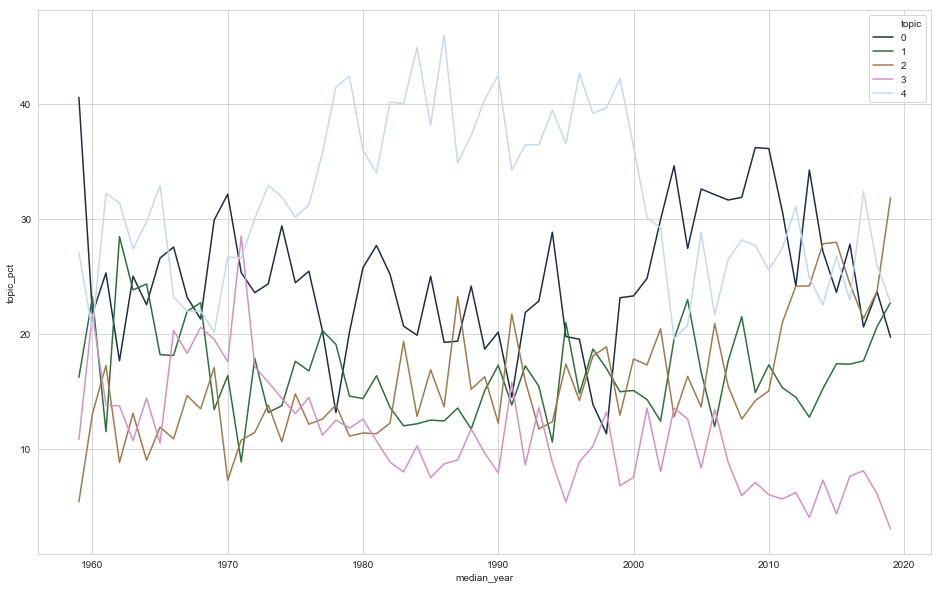

In [31]:
sns.set_style('whitegrid')
plt.figure(figsize = (16,10))
sns.lineplot(x = 'median_year',
             y = 'topic_pct',
             hue = 'topic',
             data = tracks_year_agg_corex_df_1,
             palette = sns.color_palette('cubehelix',number_of_topics));

<a id='3a7'></a>

### __3a7. CorEx - Model Results / Analysis (Version 2)__  
#### Run CorEx and incorporate "domain knowledge" by using word anchors

In [32]:
# Count vectorizer works best with CorEx
vectorizer = 'count'
anchors = [['love'],['time','life'],['beer','truck']]
number_of_topics = 5
anchor_strength = 2

In [33]:
# Run Corex Model

(tracks_corex_df_2,
 tracks_year_agg_corex_df_2,
 corex_model_2,
 corex_labels_2,
 corex_topics_columns_2) = corex_model_pipeline(tracks_df,'count',number_of_topics,anchor_strength,anchors = anchors)

In [34]:
# Display results / topics from CorEx model version 2

display_corex_topics(corex_model_2,20)

0: love, town, old, heart, bar, home, drink, city, true, whiskey, lights, hold, house, bottle, shoes, honky, black, folks, job, arms
1: said, didn, took, came, went, saw, knew, looked, walked, did, thought, couldn, told, heard, turned, years, left, life, asked, gave
2: truck, yeah, ain, beer, got, little, gonna, hey, baby, em, car, wanna, girl, gotta, good, ya, drive, boys, right, bout
3: sun, road, sky, ride, wind, red, roll, summer, like, river, moon, high, rain, rock, porch, air, water, wild, white, stars
4: daddy, man, son, country, boy, mama, big, money, kids, dad, school, momma, family, born, land, wife, mom, lord, texas, god


#### Notes from Corex Version 2:  
- Topic 0: Anchored with the word "love" and has decreased drastically since the 1960s. We can explore this further in version 3  
- Topic 1: Topics anchored with the words "time" and "life" don't provide much of a result.  
- Topic 2: Anchored with the words "truck" and "beer"; words / themes commonly found in "bro country" - as expected, this has seen a drastic increase since the 1960s.  
- Topic 3: When we use the above anchors, we're revealed themes that literally describe "country". Country singers enjoy incorporating themes that describe their lives and country.  
- Topic 4: Family is a common theme found within country music. 

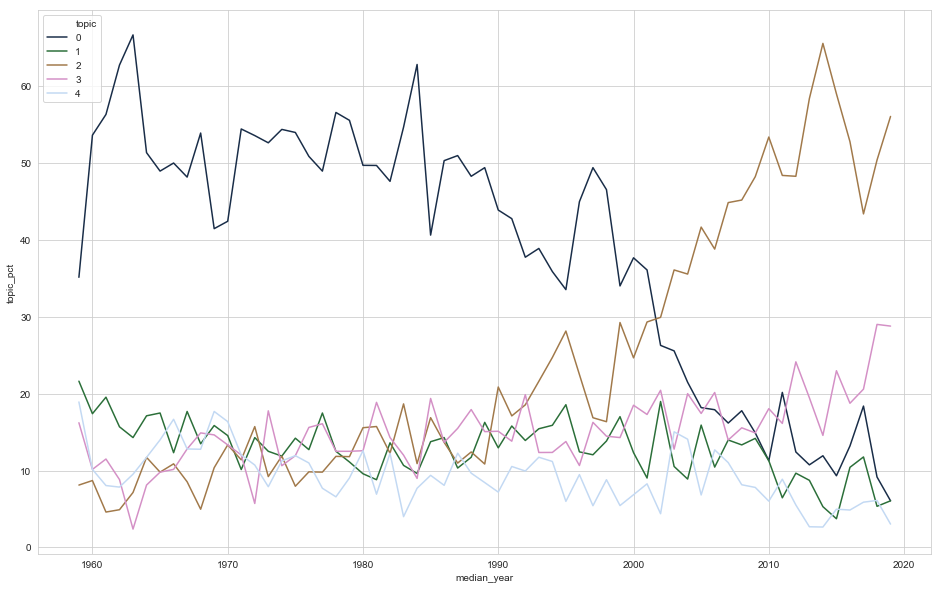

In [35]:
sns.set_style('whitegrid')
plt.figure(figsize = (16,10))
sns.lineplot(x = 'median_year',
             y = 'topic_pct',
             hue = 'topic',
             data = tracks_year_agg_corex_df_2,
             palette = sns.color_palette('cubehelix',number_of_topics))

plt.legend(loc = 'upper left');

<a id='3a8'></a>

### __3a8. CorEx - Model Results / Analysis (Version 3)__  
#### Run CorEx and use the same word anchor several times to explore how the same word is used in different contexts.

In [36]:
# Count vectorizer works best with CorEx
vectorizer = 'count'

# How is love used differently across country songs?
anchors = [['love'],['love'],['love'],['love']]
number_of_topics = 5

anchor_strength = 2

In [37]:
# Run Corex Model

(tracks_corex_df_3,
 tracks_year_agg_corex_df_3,
 corex_model_3,
 corex_labels_3,
 corex_topics_columns_3) = corex_model_pipeline(tracks_df,'count',number_of_topics,anchor_strength,anchors = anchors)

In [38]:
# Display results / topics from CorEx model version 3

display_corex_topics(corex_model_3,20)

0: yeah, ain, love, got, gonna, baby, wanna, gotta, hey, like, right, em, bout, bar, don, beer, good, girl, drink, ya
1: love, sun, sky, summer, wind, rain, river, water, moon, land, city, snow, train, trees, sea, high, tree, fields, fly, air
2: love, little, car, big, heart, money, mama, boys, kids, boy, house, home, girls, school, friday, saturday, dog, job, work, pretty
3: love, truck, country, old, town, road, ride, red, radio, roll, drive, boots, hot, cowboy, rock, guitar, dirt, jeans, song, white
4: said, daddy, man, son, took, years, came, went, god, wife, saw, looked, didn, knew, dad, turned, heard, family, walked, sat


#### Notes from Corex Version 3:  
- Topic 0: Love for beer and girls have become increasingly popular themes in recent years.  
- Topic 1,2,3: Love used in the context of one's family and country have become decreasingly popular in recent years.

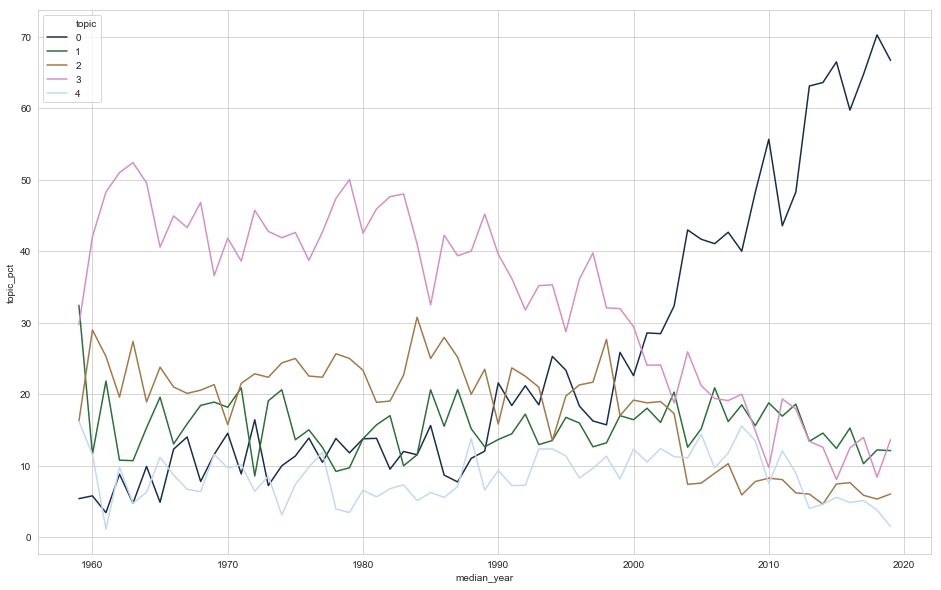

In [39]:
sns.set_style('whitegrid')
plt.figure(figsize = (16,10))
sns.lineplot(x = 'median_year',
             y = 'topic_pct',
             hue = 'topic',
             data = tracks_year_agg_corex_df_3,
             palette = sns.color_palette('cubehelix',number_of_topics))

plt.legend(loc = 'upper left');

<a id='3a9'></a>

### __3a9. CorEx - Model Results / Analysis - Explore Word Anchors__  
#### Explore CorEx model and incorporate word anchors to force topics and highlight hidden themes

In [40]:
vectorizer = 'count'
number_of_topics = 5

# Increase anchor strength to force topics
anchor_strength = 6

# Start with love and family as word anchors
anchors = [['love'],['family']]

(tracks_corex_df_,
 tracks_year_agg_corex_df_,
 corex_model_,
 corex_labels_,
 corex_topics_columns_) = corex_model_pipeline(tracks_df,'count',number_of_topics,anchor_strength,anchors = anchors)

display_corex_topics(corex_model_,10)

0: love, sweet, hearts, lovers, vows, lifetime, lover, affair, live, locked
1: family, said, daddy, son, man, years, went, took, wife, came
2: little, got, bar, beer, drink, girl, night, em, right, good
3: yeah, ain, truck, car, road, like, hey, red, gonna, drive
4: country, town, big, old, money, city, heart, cowboy, south, texas


#### The most distinct topic above (aside from the topics that were highlighted with anchors) seems to be topic 3 with songs about driving trucks, cars, etc.

In [41]:
vectorizer = 'count'
number_of_topics = 5

# Increase anchor strength to force topics
anchor_strength = 6

# Start with love and family as word anchors
anchors = [['love'],['family'],['truck']]

(tracks_corex_df_,
 tracks_year_agg_corex_df_,
 corex_model_,
 corex_labels_,
 corex_topics_columns_) = corex_model_pipeline(tracks_df,'count',number_of_topics,anchor_strength,anchors = anchors)

display_corex_topics(corex_model_,10)

0: love, sweet, hearts, puttin, lovers, vows, lifetime, devil, granted, lover
1: family, said, daddy, man, son, years, went, took, wife, mama
2: truck, got, ain, beer, bar, em, hey, gonna, boys, drink
3: yeah, little, like, red, baby, girl, road, car, wanna, roll
4: country, town, big, old, city, heart, money, guitar, land, cowboy


#### The most distinct topic above (aside from the topics that were highlighted with anchors) seems to be topic 4 with songs about country and towns.

In [42]:
vectorizer = 'count'

# Increase number of topics to reveal more themes
number_of_topics = 6

# Increase anchor strength to force topics
anchor_strength = 6

# Start with love and family as word anchors
anchors = [['love'],['family'],['truck'],['country']]

(tracks_corex_df_,
 tracks_year_agg_corex_df_,
 corex_model_,
 corex_labels_,
 corex_topics_columns_) = corex_model_pipeline(tracks_df,'count',number_of_topics,anchor_strength,anchors = anchors)

display_corex_topics(corex_model_,10)

0: love, true, forever, sweet, hearts, lovers, vows, lifetime, devil, granted
1: family, said, daddy, son, man, years, god, mama, came, wife
2: truck, yeah, ain, got, little, gonna, baby, hey, like, wanna
3: country, music, song, hank, hillbilly, holler, broadway, deere, fiddle, rifle
4: bar, car, beer, drink, home, money, heart, house, friday, honky
5: town, big, old, road, ride, city, sun, summer, wind, white


#### The most distinct topic above (aside from the topics that were highlighted with anchors) seems to be topic 4 with songs about beer

In [43]:
vectorizer = 'count'

# Increase number of topics to reveal more themes
number_of_topics = 8

# Increase anchor strength to force topics
anchor_strength = 6

# Start with love and family as word anchors
anchors = [['love'],['family'],['truck'],['country'],['beer']]

(tracks_corex_df_,
 tracks_year_agg_corex_df_,
 corex_model_,
 corex_labels_,
 corex_topics_columns_) = corex_model_pipeline(tracks_df,'count',number_of_topics,anchor_strength,anchors = anchors)

display_corex_topics(corex_model_,10)

0: love, true, forever, sweet, hearts, lovers, vows, lifetime, concrete, devil
1: family, daddy, man, kids, son, mama, wife, dad, years, boy
2: truck, road, drive, town, radio, red, ride, car, roll, gas
3: country, city, old, cowboy, big, texas, tennessee, boots, land, guitar
4: beer, bar, drink, honky, boys, em, tonk, whiskey, money, girls
5: yeah, little, baby, like, girl, hey, night, head, bed, hair
6: said, didn, took, came, went, saw, knew, looked, walked, did
7: got, ain, gonna, don, right, gotta, wanna, good, know, better


In [44]:
vectorizer = 'count'

# Increase number of topics to reveal more themes
number_of_topics = 10

# Increase anchor strength to force topics
anchor_strength = 6

# Start with love and family as word anchors
anchors = [['love'],['family'],['truck'],['country'],['beer'],['girl']]

(tracks_corex_df_,
 tracks_year_agg_corex_df_,
 corex_model_,
 corex_labels_,
 corex_topics_columns_) = corex_model_pipeline(tracks_df,'count',number_of_topics,anchor_strength,anchors = anchors)

display_corex_topics(corex_model_,10)

0: love, true, sweet, hearts, puttin, lovers, vows, lifetime, devil, tender
1: family, daddy, man, son, kids, mama, wife, dad, god, years
2: truck, pickup, luck, tailgate, hood, backed, limit, semi, mack, cussin
3: country, music, hank, roads, hillbilly, broadway, fiddle, rifle, singers, boot
4: beer, bar, honky, drink, tonk, whiskey, party, jukebox, drinkin, friday
5: girl, world, whirl, lips, marry, curls, lucky, shy, pearls, memories
6: don, say, know, think, just, tell, cause, make, really, ve
7: said, took, didn, came, went, saw, knew, looked, walked, thought
8: yeah, like, ain, baby, gonna, wanna, roll, radio, road, sun
9: little, got, town, big, old, money, heart, boy, car, boys
